# Neural Object Detection: Practice
## Part 1: SSD inference 

*Ilya Zakharkin, November 2020*

---
### This notebook requires a GPU runtime to run.
### Please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"
---

Previous year there was a [good Computer Vision practice lesson](https://www.youtube.com/watch?v=XSPYe4-y4HE) (RUS), its [notebooks](https://drive.google.com/drive/folders/1ZpS8oyI__3QvjoIwVZwur4I5e4qIExPS?usp=sharing).

This year we will master inference and training of the SSD neural network discussed on the lecture.

This notebook is based on [NVIDIA deep learning examples](https://github.com/NVIDIA/DeepLearningExamples ). 

**[Cinematic NVIDIA keynotes](https://www.youtube.com/watch?v=CKnipnFsuFo&list=PLZHnYvH1qtOYOfzAj7JZFwqtabM5XPku1) on Deep Learning 2020.**



# SSD

*Author: NVIDIA*

**Single Shot MultiBox Detector model for object detection**

_ | _
- | -
![alt](https://pytorch.org/assets/images/ssd_diagram.png) | ![alt](https://pytorch.org/assets/images/ssd.png)

In [1]:
# !pip3 install torch-tensorrt -f https://github.com/NVIDIA/Torch-TensorRT/releases

In [2]:
import torch
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

will load an SSD model pretrained on COCO dataset from Torch Hub.

Setting precision='fp16' will load a checkpoint trained with [mixed precision](https://arxiv.org/abs/1710.03740) into architecture enabling execution on [Tensor Cores](https://developer.nvidia.com/tensor-cores).
Handling mixed precision data requires [Apex](https://github.com/NVIDIA/apex) library.



### Model Description

This SSD300 model is based on the
[SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper, which
describes SSD as “a method for detecting objects in images using a single deep neural network".
The input size is fixed to 300x300.

The main difference between this model and the one described in the paper is in the backbone.
Specifically, the VGG model is obsolete and is replaced by the ResNet-50 model.

From the
[Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012)
paper, the following enhancements were made to the backbone:
*   The conv5_x, avgpool, fc and softmax layers were removed from the original classification model.
*   All strides in conv4_x are set to 1x1.

The backbone is followed by 5 additional convolutional layers.
In addition to the convolutional layers, we attached 6 detection heads:
*   The first detection head is attached to the last conv4_x layer.
*   The other five detection heads are attached to the corresponding 5 additional layers.

Detector heads are similar to the ones referenced in the paper, however,
they are enhanced by additional BatchNorm layers after each convolution.

### Example

In the example below we will use the pretrained SSD model loaded from Torch Hub to detect objects in sample images and visualize the result.

To run the example you need some extra python packages installed.
These are needed for preprocessing images and visualization.

In [3]:
%%bash
pip install numpy scipy scikit-image matplotlib

For convenient and comprehensive formatting of input and output of the model, load a set of utility methods.

In [4]:
# List of available models in PyTorch Hub from Nvidia/DeepLearningExamples
torch.hub.list('NVIDIA/DeepLearningExamples:torchhub')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


['nvidia_convnets_processing_utils',
 'nvidia_efficientnet',
 'nvidia_efficientnet_b0',
 'nvidia_efficientnet_b4',
 'nvidia_efficientnet_widese_b0',
 'nvidia_efficientnet_widese_b4',
 'nvidia_resneXt',
 'nvidia_resnet50',
 'nvidia_resnext101_32x4d',
 'nvidia_se_resnext101_32x4d',
 'nvidia_ssd',
 'nvidia_ssd_processing_utils',
 'nvidia_tacotron2',
 'nvidia_tts_utils',
 'nvidia_waveglow']

In [5]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


File that has contains all this code:

In [6]:
!cat /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/hubconf.py

import os
import sys

from PyTorch.Detection.SSD.ssd import nvidia_ssd, nvidia_ssd_processing_utils
sys.path.append(os.path.join(sys.path[0], 'PyTorch/Detection/SSD'))

from PyTorch.Classification.ConvNets.image_classification.models import resnet50 as nvidia_resnet50
from PyTorch.Classification.ConvNets.image_classification.models import resnext101_32x4d as nvidia_resnext101_32x4d
from PyTorch.Classification.ConvNets.image_classification.models import se_resnext101_32x4d as nvidia_se_resnext101_32x4d
from PyTorch.Classification.ConvNets.image_classification.models import efficientnet_b0 as nvidia_efficientnet_b0
from PyTorch.Classification.ConvNets.image_classification.models import efficientnet_b4 as nvidia_efficientnet_b4
from PyTorch.Classification.ConvNets.image_classification.models import efficientnet_widese_b0 as nvidia_efficientnet_widese_b0
from PyTorch.Classification.ConvNets.image_classification.models import efficientnet_widese_b4 as nvidia_efficientnet_widese_b4
from PyTo

File [utils.py](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Detection/SSD/src/utils.py) that containes Encoder and dboxes_300 code.

Now, prepare the loaded model for inference

In [7]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

Prepare input images for object detection.
(Example links below correspond to first few test images from the COCO dataset, but you can also specify paths to your local images here)

In [8]:
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg',
    'https://i.ibb.co/ZVqGsbJ/nvidia-image-300.jpg'
]

Format the images to comply with the network input and convert them to tensor.

In [9]:
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

Run the SSD network to perform object detection.

In [10]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [11]:
print(len(detections_batch))
print(len(detections_batch[0]), detections_batch[0].shape)
print(len(detections_batch[1]), detections_batch[1].shape)

2
4 torch.Size([4, 4, 8732])
4 torch.Size([4, 81, 8732])


By default, raw output from SSD network per input image contains
8732 boxes with localization and class probability distribution.
Let's filter this output to only get reasonable detections (confidence>40%) in a more comprehensive format.

In [12]:
results_per_input = utils.decode_results(detections_batch)
print(len(results_per_input), len(results_per_input[0]), 
      results_per_input[1][0].shape, results_per_input[1][1].shape, results_per_input[1][2].shape)


4 3 (20, 4) (20,) (20,)


In [13]:
best_results_per_input = [utils.pick_best(results, 0.20) for results in results_per_input]
print(len(best_results_per_input), len(best_results_per_input[0]), 
      best_results_per_input[1][0].shape, best_results_per_input[1][1].shape, best_results_per_input[1][2].shape)

4 3 (1, 4) (1,) (1,)


The model was trained on COCO dataset, which we need to access in order to translate class IDs into object names.
For the first time, downloading annotations may take a while.

In [14]:
classes_to_labels = utils.get_coco_object_dictionary()

Finally, let's visualize our detections

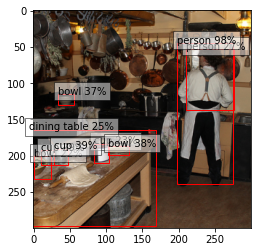

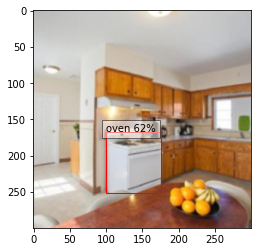

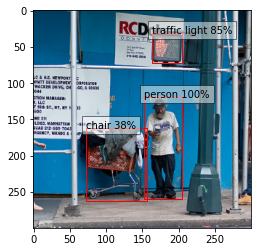

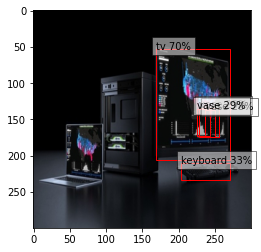

In [15]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

> To run this SSD implementation on the 4th image we needed:
- find it in Google via "Image search";
- manually resize it to 300х300;
- lower the threshold down to 20% (originally it was 40%).

Benchmark utility :

In [16]:
import time
import numpy as np

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

# Helper function to benchmark the model
def benchmark(model, input_shape=(1024, 1, 32, 32), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()

    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred_loc, pred_label  = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%100==0:
                print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output location prediction size:", pred_loc.size())
    print("Output label prediction size:", pred_label.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

We check how well the model performs **before** we use TRTorch/TensorRT:

In [17]:
# Model benchmark without TRTorch/TensorRT
model = ssd_model.eval().to("cuda")
benchmark(model, input_shape=(128, 3, 300, 300), nruns=1000)

Warm up ...
Start timing ...
Iteration 100/1000, avg batch time 602.83 ms
Iteration 200/1000, avg batch time 602.79 ms
Iteration 300/1000, avg batch time 602.75 ms
Iteration 400/1000, avg batch time 602.72 ms
Iteration 500/1000, avg batch time 602.71 ms
Iteration 600/1000, avg batch time 602.71 ms
Iteration 700/1000, avg batch time 602.70 ms
Iteration 800/1000, avg batch time 602.70 ms
Iteration 900/1000, avg batch time 602.69 ms
Iteration 1000/1000, avg batch time 602.68 ms
Input shape: torch.Size([128, 3, 300, 300])
Output location prediction size: torch.Size([128, 4, 8732])
Output label prediction size: torch.Size([128, 81, 8732])
Average batch time: 602.68 ms


After TensorRT acceleration: [follow this guide](https://nvidia.github.io/Torch-TensorRT/tutorials/use_from_pytorch.html#use-from-pytorch) (scroll down the page).

In [18]:
...Your code here!

SyntaxError: ignored

### Details
For detailed information on model input and output,
training recipies, inference and performance visit:
[github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)
and/or [NGC](https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch)

### Useful links

 - [SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper
 - [Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012) paper
 - [SSD on NGC](https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch)
 - [SSD on github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)
 - [TensorRT tutorial](https://nvidia.github.io/Torch-TensorRT/tutorials/use_from_pytorch.html#use-from-pytorch)